<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/rafi/Stage_1_Cleaning_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 1: Enhanced Data Cleaning and  Preprocessing
Objective: Analyzing both the Cleantech Media Dataset and the Cleantech Google Patent Dataset to
identify emerging trends, technologies, and potential innovation gaps in the cleantech sector

# Setup & Data Import

- Requirement: Download and load the Cleantech Media Dataset and the Cleantech Google Patent Dataset.

In [1]:
# Install necessary libraries (only required in Colab or new environments)
!pip install googletrans langdetect nest_asyncio demoji contractions unidecode num2words pyspellchecker spacy matplotlib wordcloud networkx pyLDAvis top2vec bertopic

# Import required libraries
import os
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from gensim.models import CoherenceModel
from bertopic import BERTopic
from top2vec import Top2Vec
from collections import Counter
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
from googletrans import Translator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLP resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
!python -m spacy download en_core_web_sm

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Configure necessary settings
DetectorFactory.seed = 0
translator = Translator()

# Mount Google Drive for data access
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
media_data = pd.read_csv("/content/drive/MyDrive/CLT/data/media_data/cleantech_media_dataset_v3_2024-10-28.csv")
patent_data = pd.read_json("/content/drive/MyDrive/CLT/data/patent_data/CleanTech_22-24.json", lines=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=52ff3899f1f1c3f35eeccb8d0b6f1e22c3ccc0485f791475972199d47565b771
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6920

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive


In [2]:
patent_data.head()

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'fi..."
1,US-2022239251-A1,US-202217580956-A,US,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'fir..."
2,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
4,US-11396827-B2,US-202117606042-A,US,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,20220726,[],"[{'code': 'F24S50/00', 'inventive': True, 'fir..."


In [3]:
media_data.head()

,Unnamed: 0,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,NaN,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,NaN,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,NaN,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...


# Data Collection and Cleaning


In [9]:
# Check for missing values
print("\nMissing values in patent data:")
print(patent_data.isna().sum())

print("\nMissing values in media data:")
print(media_data.isna().sum())

# Replace missing values in the 'author' column with "Unknown" after converting to string
media_data['author'] = media_data['author'].astype(str)
media_data.loc[:, 'author'] = media_data['author'].replace("nan", "Unknown")

# Convert non-hashable columns (lists) to strings before removing duplicates
patent_data = patent_data.astype(str)

# Remove duplicate entries
media_data = media_data.drop_duplicates()
patent_data = patent_data.drop_duplicates()

# Convert date columns to datetime format (safe application using `.loc[]`)
patent_data.loc[:, 'publication_date'] = pd.to_datetime(patent_data['publication_date'], errors='coerce')

# Remove unnecessary columns
patent_data = patent_data.drop(columns=["country_code", "cpc"], errors="ignore")



Missing values in patent data:
publication_number    0
application_number    0
country_code          0
title                 0
abstract              0
publication_date      0
inventor              0
cpc                   0
dtype: int64

Missing values in media data:
Unnamed: 0        0
title             0
date              0
author        20111
content           0
domain            0
url               0
dtype: int64


# Language Detection, Translation & Text Preprocessing

In [10]:
from tqdm import tqdm  # Progress bar for better visibility
tqdm.pandas()  # Enables progress tracking in Pandas

# Function to detect if a text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except Exception:
        return False

# Cache translations to avoid redundant API calls
translation_cache = {}

def translate_text(text):
    if text in translation_cache:  # Avoid redundant translations
        return translation_cache[text]

    try:
        translated = translator.translate(text, dest='en').text
        translation_cache[text] = translated
        return translated
    except:
        return text  # Return original text if translation fails

# Optimize text preprocessing using nlp.pipe()
def preprocess_texts(texts):
    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=["parser", "ner"]), total=len(texts), desc="Processing Text"):
        words = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
        processed_texts.append(" ".join(words))

    return processed_texts

# Apply translation efficiently
non_english_mask_media_title = ~media_data['title'].apply(is_english)
non_english_mask_media_content = ~media_data['content'].apply(is_english)
non_english_mask_patent_title = ~patent_data['title'].apply(is_english)
non_english_mask_patent_abstract = ~patent_data['abstract'].apply(is_english)

media_data.loc[non_english_mask_media_title, 'title'] = media_data.loc[non_english_mask_media_title, 'title'].progress_apply(translate_text)
media_data.loc[non_english_mask_media_content, 'content'] = media_data.loc[non_english_mask_media_content, 'content'].progress_apply(translate_text)
patent_data.loc[non_english_mask_patent_title, 'title'] = patent_data.loc[non_english_mask_patent_title, 'title'].progress_apply(translate_text)
patent_data.loc[non_english_mask_patent_abstract, 'abstract'] = patent_data.loc[non_english_mask_patent_abstract, 'abstract'].progress_apply(translate_text)

# Apply optimized text preprocessing
media_data['processed_text'] = preprocess_texts(media_data['content'].tolist())
patent_data['processed_text'] = preprocess_texts(patent_data['abstract'].tolist())


  0%|          | 0/1147 [00:00<?, ?it/s]<ipython-input-10-7311ef0273d0>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-10-7311ef0273d0>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
  0%|          | 0/11124 [00:00<?, ?it/s]<ipython-input-10-7311ef0273d0>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
  0%|          | 0/2420 [00:00<?, ?it/s]<ipython-input-10-7311ef0273d0>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
Processing Text: 100%|██████████| 22815/22815 [09:36<00:00, 39.59it/s]


In [18]:
# Dateipfade für Backup-Speicherung
media_data_filepath = "/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv"
patent_data_filepath = "/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv"

# Speichern der bearbeiteten Datensätze als CSV
media_data.to_csv(media_data_filepath, index=False)
patent_data.to_csv(patent_data_filepath, index=False)

print(f"\n Backup der bearbeiteten Medien-Daten gespeichert unter: {media_data_filepath}")
print(f" Backup der bearbeiteten Patent-Daten gespeichert unter: {patent_data_filepath}")


 Backup der bearbeiteten Medien-Daten gespeichert unter: /content/drive/MyDrive/CLT/data/processed_media_data_backup.csv
 Backup der bearbeiteten Patent-Daten gespeichert unter: /content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv


# Achtung ab hier ausführen: Loading the Processed Dataset in Future Sessions

In [54]:
# Load Backup
processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

# Check first 5 rows
processed_media_data_backup.head(50)

,Unnamed: 0,title,date,author,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,Unknown,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,Unknown,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,Unknown,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch MW float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,Unknown,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,Unknown,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...
5,31129,Judge Rules Energy Transfer Owes $ 410M For Br...,2022-01-03,Unknown,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/judge-rules-en...,sign get good natural gas news datum follow to...
6,42776,BP: Commitment to Scotland is ‘ unique differe...,2022-01-03,Unknown,['BP’ s “ long-term ” commitment to Scotland i...,energyvoice,https://www.energyvoice.com/renewables-energy-...,BP long term commitment Scotland key selling p...
7,65565,Everyone wants to start a solar panel factory ...,2022-01-03,Unknown,"['The U.S. solar manufacturing industry, which...",solarpowerworldonline,https://www.solarpowerworldonline.com/2022/01/...,the solar manufacturing industry today supply ...
8,42777,Sir Jim McDonald: ScotWind will tee country up...,2022-01-03,Unknown,['“ Convergence ” is how Sir Jim McDonald desc...,energyvoice,https://www.energyvoice.com/renewables-energy-...,Convergence Sir Jim McDonald describe way scot...
9,98160,Solar for polytunnel greenhouses – pv magazine...,2022-01-03,Unknown,['Israeli researchers have tested organic PV m...,pv-magazine,https://www.pv-magazine.com/2022/01/03/solar-f...,israeli researcher test organic pv module powe...


In [55]:
processed_patent_data_backup.head(50)

,publication_number,application_number,title,abstract,publication_date,inventor,processed_text
0,US-2022239235-A1,US-202217717397-A,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,2022-07-28 00:00:00,[],disclose adaptable DC AC inverter system opera...
1,US-2022239251-A1,US-202217580956-A,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",2022-07-28 00:00:00,[],in accordance example embodiment solar energy ...
2,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum steuern einer Windenergieanlage ...
3,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum steuern einer Windenergieanlage ...
4,US-11396827-B2,US-202117606042-A,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,2022-07-26 00:00:00,[],a control method optimize solar power efficien...
5,CN-217015449-U,CN-202220853486-U,Automatic desilting channel of diversion type ...,本实用新型公开了一种引水式水电站的自动沉沙渠，包括渠体、柔性扰流杆、混凝土斜块和抽沙机构，渠...,2022-07-22 00:00:00,[],NaN
6,CN-217015449-U,CN-202220853486-U,Automatic desilting channel of diversion type ...,The utility model discloses an automatic sand ...,2022-07-22 00:00:00,[],the utility model disclose automatic sand sett...
7,CN-217015449-U,CN-202220853486-U,一种引水式水电站的自动沉沙渠,The utility model discloses an automatic sand ...,2022-07-22 00:00:00,[],the utility model disclose automatic sand sett...
8,CN-114778667-A,CN-202210212793-A,一种水电站螺栓监测装置、方法及电子设备,The invention discloses a hydropower station b...,2022-07-22 00:00:00,[],the invention disclose hydropow station bolt m...
9,CN-114778667-A,CN-202210212793-A,Hydropower station bolt monitoring device and ...,The invention discloses a hydropower station b...,2022-07-22 00:00:00,[],the invention disclose hydropow station bolt m...


# Exploratory Data Analysis (EDA)

In [56]:
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tqdm import tqdm

# Load English NLP model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Sentiment Analysis

In [57]:
from tqdm import tqdm

def perform_sentiment_analysis(texts):
    results = []
    for text in tqdm(texts, desc="Performing Sentiment Analysis"):
        sentiment_score = sia.polarity_scores(str(text))['compound'] if isinstance(text, str) else 0
        results.append(sentiment_score)
    return results

processed_media_data_backup['sentiment'] = perform_sentiment_analysis(processed_media_data_backup['processed_text'])
processed_patent_data_backup['sentiment'] = perform_sentiment_analysis(processed_patent_data_backup['processed_text'])


Performing Sentiment Analysis:   6%|▌         | 1140/20111 [00:08<02:18, 136.89it/s]


KeyboardInterrupt: 

In [16]:
print(processed_media_data_backup[['processed_text', 'sentiment']].head())
print(processed_patent_data_backup[['processed_text', 'sentiment']].head())

                                      processed_text  sentiment
0  chinese automotive startup XPeng show one dram...     0.9953
1  Sinopec lay plan build large green hydrogen pr...     0.9963
2  Huaneng Power International switch MW float pv...     0.9959
3  accord iranian authority currently renewable e...     0.9926
4  sign get good natural gas news datum follow to...     0.9948
                                      processed_text  sentiment
0  disclose adaptable DC AC inverter system opera...     0.5106
1  in accordance example embodiment solar energy ...     0.4939
2  Verfahren zum steuern einer Windenergieanlage ...    -0.9948
3  Verfahren zum steuern einer Windenergieanlage ...    -0.9948
4  a control method optimize solar power efficien...     0.9136


# Temporal Analysis

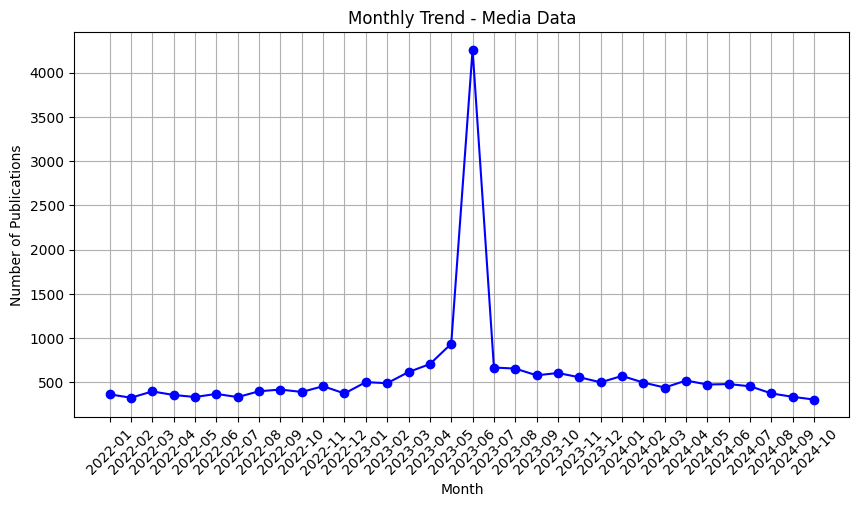

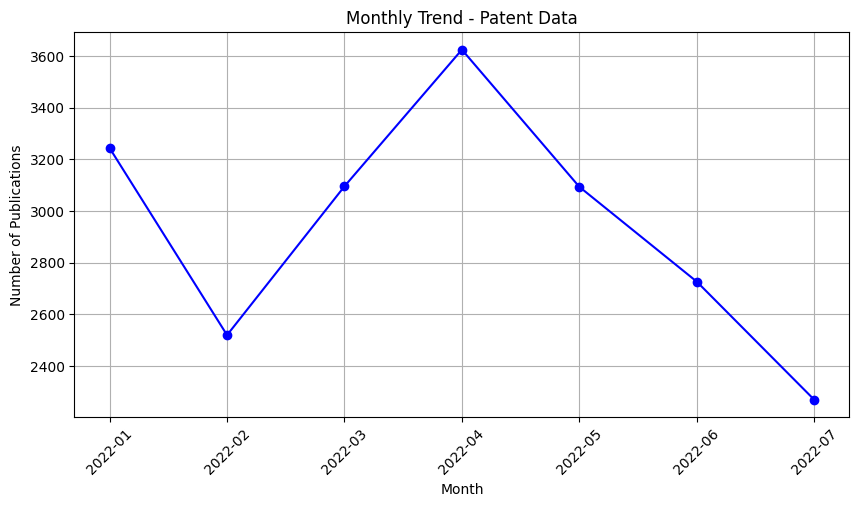

In [35]:
import matplotlib.pyplot as plt

# Check and convert date columns
if 'date' in processed_media_data_backup.columns:
    processed_media_data_backup['date'] = pd.to_datetime(processed_media_data_backup['date'], errors='coerce')

if 'publication_date' in processed_patent_data_backup.columns:
    processed_patent_data_backup['publication_date'] = pd.to_datetime(processed_patent_data_backup['publication_date'], errors='coerce')

# Updated function to handle different column names
def plot_monthly_trend(df, title, date_column):
    if date_column in df.columns:  # Ensure the column exists
        df['month'] = df[date_column].dt.strftime('%Y-%m')  # Format as "YYYY-MM"
        monthly_counts = df.groupby('month').size()

        plt.figure(figsize=(10, 5))
        plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='blue')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
        plt.title(f'Monthly Trend - {title}')
        plt.xlabel('Month')
        plt.ylabel('Number of Publications')
        plt.grid(True)
        plt.show()
    else:
        print(f"Column '{date_column}' not found in {title} dataset.")

# Run monthly analysis with correct column names
plot_monthly_trend(processed_media_data_backup, 'Media Data', 'date')
plot_monthly_trend(processed_patent_data_backup, 'Patent Data', 'publication_date')


<ipython-input-36-972addf7f7c9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df[date_column].dt.strftime('%Y-%m')  # Format as "YYYY-MM"


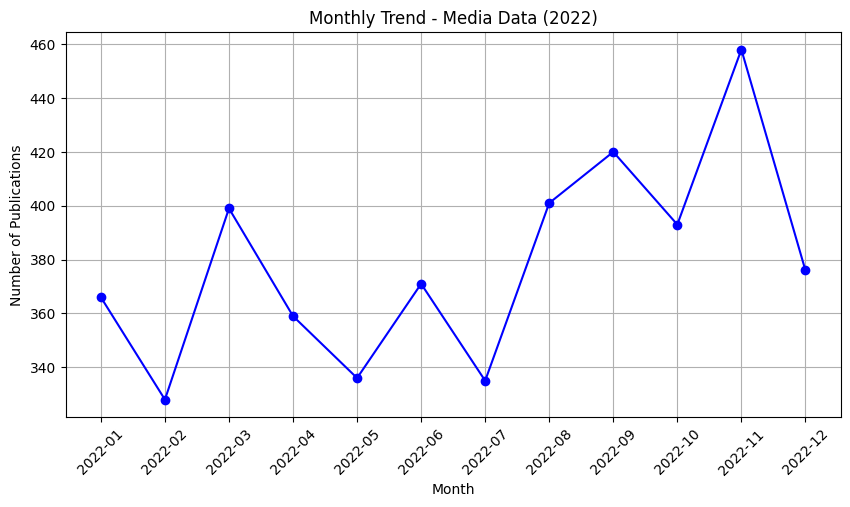

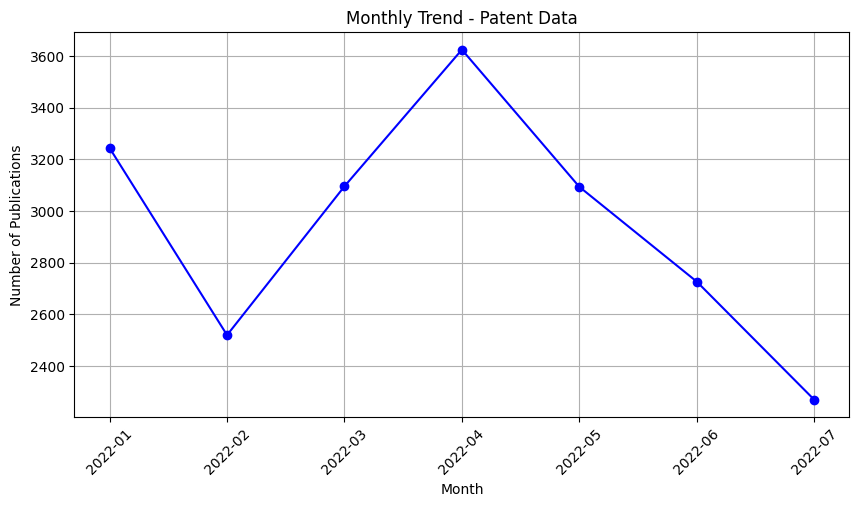

In [36]:
import matplotlib.pyplot as plt

# Check and convert date columns
if 'date' in processed_media_data_backup.columns:
    processed_media_data_backup['date'] = pd.to_datetime(processed_media_data_backup['date'], errors='coerce')

if 'publication_date' in processed_patent_data_backup.columns:
    processed_patent_data_backup['publication_date'] = pd.to_datetime(processed_patent_data_backup['publication_date'], errors='coerce')

# Filter media dataset for 2022 only
processed_media_data_2022 = processed_media_data_backup[
    processed_media_data_backup['date'].dt.year == 2022
]

# Updated function to handle different column names
def plot_monthly_trend(df, title, date_column):
    if date_column in df.columns:  # Ensure the column exists
        df['month'] = df[date_column].dt.strftime('%Y-%m')  # Format as "YYYY-MM"
        monthly_counts = df.groupby('month').size()

        plt.figure(figsize=(10, 5))
        plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='blue')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
        plt.title(f'Monthly Trend - {title}')
        plt.xlabel('Month')
        plt.ylabel('Number of Publications')
        plt.grid(True)
        plt.show()
    else:
        print(f"Column '{date_column}' not found in {title} dataset.")

# Run monthly analysis with correct column names
plot_monthly_trend(processed_media_data_2022, 'Media Data (2022)', 'date')
plot_monthly_trend(processed_patent_data_backup, 'Patent Data', 'publication_date')


# Word Cloud Generation

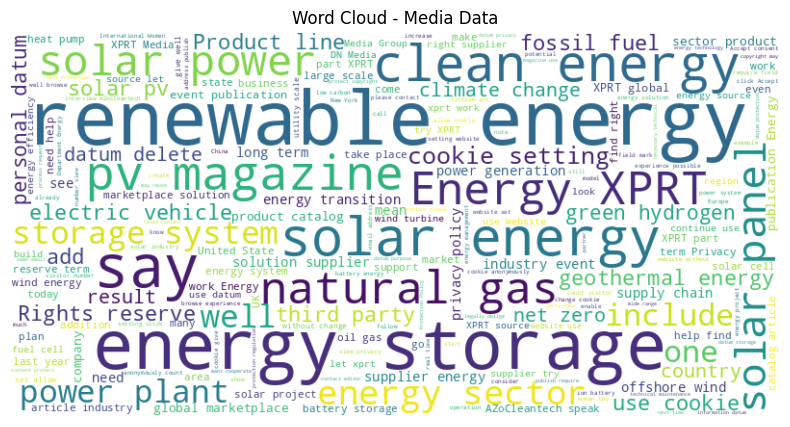

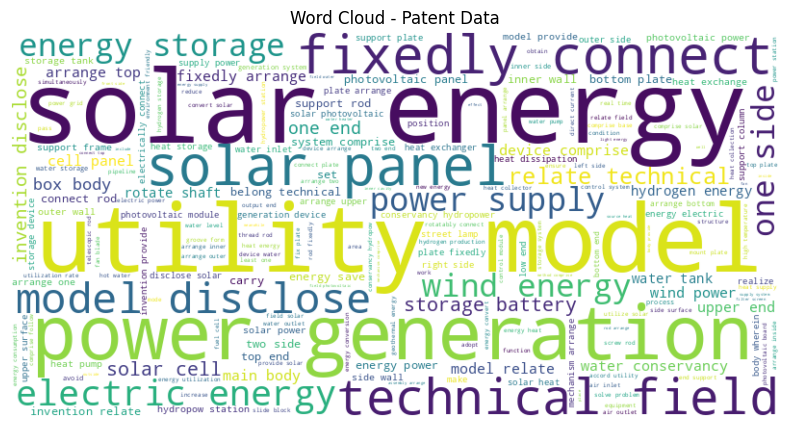

In [26]:
# Creating word clouds to visualize frequently used words.
all_words_media = ' '.join(processed_media_data_backup['processed_text'].dropna().astype(str))
all_words_patent = ' '.join(processed_patent_data_backup['processed_text'].dropna().astype(str))

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(all_words_media, 'Word Cloud - Media Data')
generate_wordcloud(all_words_patent, 'Word Cloud - Patent Data')


# Named Entity Recognition (NER) Problematisch

In [32]:
print("Missing values in processed_text (Media):", processed_media_data_backup['processed_text'].isna().sum())
print("Missing values in processed_text (Patent):", processed_patent_data_backup['processed_text'].isna().sum())
# Drop rows where 'processed_text' is NaN
processed_patent_data_backup = processed_patent_data_backup.dropna(subset=['processed_text'])



Missing values in processed_text (Media): 0
Missing values in processed_text (Patent): 2239


In [39]:
import spacy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm

# Lade das spaCy-Modell
nlp = spacy.load("en_core_web_sm")

# Funktion zur Extraktion von Named Entities (Unternehmen, Produkte/Technologien)
def extract_entities(texts):
    entities_list = []
    docs = nlp.pipe(texts, disable=["parser", "tagger"])  # Performance-Optimierung
    for doc in docs:
        entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT']]
        entities_list.append(entities)
    return entities_list

# Wende die Funktion auf die Daten an (mit Fortschrittsanzeige)
tqdm.pandas()
processed_media_data_backup['entities'] = extract_entities(processed_media_data_backup['processed_text'].tolist())
processed_patent_data_backup['entities'] = extract_entities(processed_patent_data_backup['processed_text'].tolist())

# Kombiniere alle extrahierten Entitäten für die Co-Occurrence-Analyse
all_entities = processed_media_data_backup['entities'].tolist() + processed_patent_data_backup['entities'].tolist()


#Erstellung der Co-Occurrence-Matrix
def create_cooccurrence_matrix(entities_list):
    cooccurrence = Counter()
    for entities in entities_list:
        unique_entities = list(set(entities))  # Entfernt doppelte Erwähnungen in einem Dokument
        for i in range(len(unique_entities)):
            for j in range(i + 1, len(unique_entities)):
                cooccurrence[(unique_entities[i], unique_entities[j])] += 1
    return cooccurrence

# Erstelle die Co-Occurrence-Matrix
cooccurrence_data = create_cooccurrence_matrix(all_entities)



/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

# Visualisierung des Netzwerks mit NetworkX

In [ ]:
def plot_network_graph(cooccurrence):
    G = nx.Graph()

    # Knoten und Kanten mit Gewichtung hinzufügen
    for (entity1, entity2), weight in cooccurrence.items():
        G.add_edge(entity1, entity2, weight=weight)

    # Setze Layout und zeichne das Netzwerk
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout-Optimierung
    node_size = [1000 * nx.degree_centrality(G).get(node, 0.1) for node in G.nodes()]  # Größe basierend auf Zentralität
    nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=10, edge_color='gray', alpha=0.7)

    plt.title("Entity Relationship Network")
    plt.show()

# Visualisiere das Netzwerk
plot_network_graph(cooccurrence_data)


# Network Graph Analysis

In [ ]:
# Visualizing relationships between extracted entities using NetworkX.
def plot_network_graph(cooccurrence):
    G = nx.Graph()

    for (entity1, entity2), weight in cooccurrence.items():
        G.add_edge(entity1, entity2, weight=weight)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=10, edge_color='gray')
    plt.title("Entity Relationship Network")
    plt.show()

plot_network_graph(cooccurrence_data)


# LAST CHECKS
Outputs:
- Notebook with data cleaning and preprocessing steps.
- Notebook with EDA visualizations on e.g. hidden topics and the detailed comparison between
the two datasets.

#Luca:
Sentiment Analysis, Temporal überprüfen
Neural fehlt

# Topic-Modeling

In [62]:
# Load and preprocess data
documents = processed_media_data_backup['processed_text'].dropna().tolist() + \
            processed_patent_data_backup['processed_text'].dropna().tolist()

# Ensure that the directory for saving models exists
save_path = "/content/drive/MyDrive/CLT/models/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# LDA

In [64]:
from gensim.models.ldamodel import LdaModel  # Correct import

id2word = corpora.Dictionary([text.split() for text in documents])
corpus = [id2word.doc2bow(text.split()) for text in documents]

lda_model = LdaModel(
    corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
    update_every=1, chunksize=500, passes=20, alpha='auto', per_word_topics=True
)

# Extract topics
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn=20)
        word_dict[f'Topic #{i+1:02d}'] = [word[0] for word in words]
    return pd.DataFrame(word_dict)

lda_topics_df = get_lda_topics(lda_model, 10)
print("\nLDA Topics:")
print(lda_topics_df)

# Coherence Score Evaluation
lda_coherence_model = CoherenceModel(model=lda_model, texts=[text.split() for text in documents], dictionary=id2word, coherence='c_v')
lda_coherence_score = lda_coherence_model.get_coherence()
print(f"LDA Coherence Score: {lda_coherence_score:.4f}")

# Save LDA model
lda_model.save(save_path + "lda_model.gensim")

# LDA Visualization
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_vis)


LDA Topics:
      Topic #01   Topic #02    Topic #03    Topic #04     Topic #05  \
0       silicon       hinge       method         heat    geothermal   
1         datum         the          the        water         rotor   
2            pv      energy        model       energy          well   
3          cell       solar        datum         pipe          deep   
4   ultraviolet         say         time          air            de   
5           the        year         step          the          rock   
6        module        also    invention     hydrogen        convey   
7         solar      market          use       system       shallow   
8           use  investment      station        solar      drilling   
9           may    capacity    rainwater         tank   underground   
10      website      spiral        level  temperature           the   
11        wafer     project  circulation      storage        mining   
12      battery         new  information      heating         ax

# Non-Negative Matrix Factorization (NMF)

In [65]:
vectorizer = CountVectorizer(analyzer='word', max_features=1000, stop_words='english')
x_counts = vectorizer.fit_transform(documents)
transformer = TfidfTransformer()
x_tfidf = transformer.fit_transform(x_counts)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

nmf_model = NMF(n_components=10, init='nndsvd', random_state=42)
nmf_model.fit(xtfidf_norm)

# Extract topics
def get_nmf_topics(model, vectorizer, num_topics=10, n_top_words=10):
    feat_names = vectorizer.get_feature_names_out()
    word_dict = {}

    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        words = [re.sub(r'\S*@\S*\s?', '', sent) for sent in words]
        words = [re.sub(r'\s+', ' ', sent) for sent in words]
        words = [re.sub(r"\'", "", sent) for sent in words]
        word_dict[f'Topic #{i+1:02d}'] = words

    return pd.DataFrame(word_dict)

nmf_topics_df = get_nmf_topics(nmf_model, vectorizer)
print("\nNMF Topics:")
print(nmf_topics_df)


NMF Topics:
  Topic #01   Topic #02    Topic #03     Topic #04   Topic #05    Topic #06  \
0     plate      energy         heat        module        wind        water   
1       rod       solar   geothermal  photovoltaic       blade         pipe   
2   connect     project      heating         solar       power         tank   
3     frame   renewable          air         power   generator         pump   
4   fixedly          pv       energy         panel      energy        inlet   
5   arrange  geothermal         pump       control  generation       device   
6       fix         say         pipe        energy     turbine  conservancy   
7   support         new     exchange          cell      rotate       outlet   
8    rotate        year  temperature        supply       shaft         flow   
9       end     company    exchanger       battery   invention     hydropow   

  Topic #07   Topic #08  Topic #09 Topic #10  
0     layer    hydrogen       body      lamp  
1      cell  production

# Cosine Similarity Document Recommendation

In [66]:
titles = media_data['title'].tolist() + patent_data['title'].tolist()

# Create TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(documents)

# Compute cosine similarity
def cosine_sim(text1, text2):
    tfidf_score = TfidfVectorizer().fit_transform([text1, text2])
    return ((tfidf_score * tfidf_score.T).A)[0, 1]

# Find most similar documents
def closest_doc_name(sentence, docs, num_results=10):
    query_tfidf = vectorizer.transform([sentence])
    cosine_similarities = (tfidf_matrix * query_tfidf.T).toarray().flatten()
    top_indices = np.argsort(cosine_similarities)[-num_results:][::-1]
    return [(titles[i], cosine_similarities[i]) for i in top_indices]

# Example search query
recommended_docs = closest_doc_name("renewable energy", documents)

print("\nTop recommended documents:")
for title, score in recommended_docs:
    print(f"{title} - Similarity: {score:.4f}")

# Save TF-IDF model
with open(save_path + "tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open(save_path + "tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)


Top recommended documents:
Unlocking the power of renewables with energy storage - Similarity: 0.6776
Debunking Myths: The Truth About Renewable Energy - Similarity: 0.6232
Creating Renewable Energy Integration Solutions - Similarity: 0.5939
Why do Renewable Energy Meters appear? - Similarity: 0.5818
Shaping The Future: Insights From IRENA's 2024 Renewable Energy Statistics Report - Similarity: 0.5394
Renewable Energy Compliance ( Renewable Energy) Articles - Similarity: 0.5227
Analyzing India's Renewable Energy Milestone: Solar Dominance Power Generation In March 2024 - Similarity: 0.5224
Solar And Wind Capture ~82% of India's Renewable Energy Generation in December 2023 - Similarity: 0.5223
Energy Mix: From Coal to Renewables - Similarity: 0.5130
Energy Assets Companies and Suppliers ( Energy Management) - Similarity: 0.5070


NameError: name 'pickle' is not defined

In [ ]:
#Run the code and check the extracted topics
print(nmf_topics_df)

In [ ]:
#Test different numbers of topics or words
nmf_topics_df = get_nmf_topics(nmf_model, vectorizer, num_topics=5, n_top_words=15)


# Test document recommendations for new search terms:

In [47]:
print(closest_doc_name("solar power", documents))

NameError: name 'closest_doc_name' is not defined

# Interpret NMF topics:


In [ ]:
print(nmf_topics_df)


# BERTopic (Rafi)

In [ ]:
bertopic_model = BERTopic(verbose=True)
bertopic_topics, probs = bertopic_model.fit_transform(documents)

print("\nBERTopic Topics Overview:")
print(bertopic_model.get_topic_info())

# Evaluate BERTopic coherence using C_v score
bertopic_coherence_model = CoherenceModel(topics=[bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics()))],
                                          texts=texts, dictionary=id2word, coherence='c_v')
bertopic_coherence_score = bertopic_coherence_model.get_coherence()
print(f"BERTopic Coherence Score: {bertopic_coherence_score:.4f}")

# Save BERTopic model
bertopic_model.save(save_path + "bertopic_model")

# Visualizations
bertopic_model.visualize_barchart()
bertopic_model.visualize_topics()
bertopic_model.visualize_heatmap()

# ALVARO

#  Top2Vec (Alvaro)

In [61]:
top2vec_model = Top2Vec(documents, embedding_model="universal-sentence-encoder")

print("\nTop2Vec Topic Overview:")
print(top2vec_model.get_topics())

# Save Top2Vec model
top2vec_model.save(save_path + "top2vec_model")

# Evaluate Top2Vec coherence
top2vec_topics, _ = top2vec_model.get_topics()
top2vec_coherence_model = CoherenceModel(topics=top2vec_topics, texts=texts, dictionary=id2word, coherence='c_v')
top2vec_coherence_score = top2vec_coherence_model.get_coherence()
print(f"Top2Vec Coherence Score: {top2vec_coherence_score:.4f}")

2025-03-10 23:20:22,286 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2025-03-10 23:21:02,264 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2025-03-10 23:21:42,982 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-03-10 23:23:22,804 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-03-10 23:24:52,207 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-03-10 23:24:59,858 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics



Top2Vec Topic Overview:
(array([['renewables', 'megawatt', 'sustainability', ..., 'skoda',
        'environmental', 'turbines'],
       ['powerwall', 'solar', 'renewables', ..., 'genesis', 'congress',
        'institutional'],
       ['geothermal', 'kilowatt', 'renewables', ..., 'ces',
        'underserved', 'fission'],
       ...,
       ['modulation', 'frequency', 'primary', ..., 'turbines',
        'municipality', 'inductor'],
       ['spraying', 'directorate', 'ac', ..., 'management', 'entity',
        'efficacy'],
       ['faulty', 'anomaly', 'error', ..., 'critical', 'nonlinear',
        'methodology']], dtype='<U15'), array([[0.2835221 , 0.28100598, 0.26811415, ..., 0.17130831, 0.17122173,
        0.17066947],
       [0.17217132, 0.16638294, 0.16542836, ..., 0.11863942, 0.11805773,
        0.11783655],
       [0.26910406, 0.2338312 , 0.22404972, ..., 0.1518581 , 0.15172012,
        0.15170655],
       ...,
       [0.3413754 , 0.32220435, 0.21050672, ..., 0.14196473, 0.14175627,

ValueError: too many values to unpack (expected 2)

# Evaluation (Alvaro)

In [ ]:
print(f"LDA Coherence: {lda_coherence_score}")
print(f"NMF Coherence: {nmf_coherence_score}")
print(f"BERTopic Coherence: {bertopic_coherence_score}")
print(f"Top2Vec Coherence: {top2vec_coherence_score}")


In [ ]:
print(closest_doc_name("solar power", documents))


# Hierarchical topic modeling (Alvaro)

# Visualize and interpret  (Alvaro)

Visualize and interpret the topics, comparing emerging trends in media publications against
focuses of recent patents.